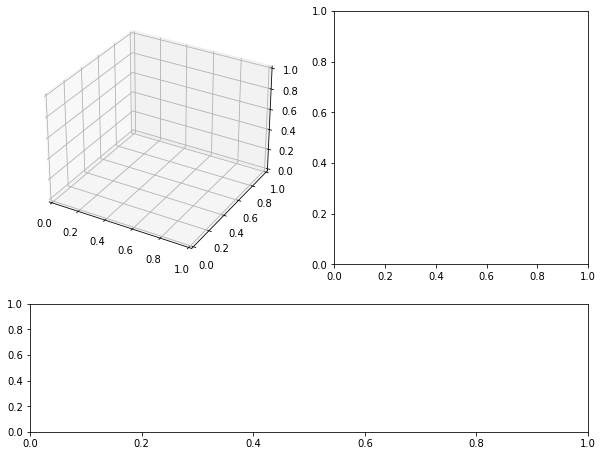

In [3]:
import numpy as np
# from tqdm import tqdm #プログレスバーを表示させてくれる
import jax,jaxlib
import jax.numpy as jnp
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

class UKR:
    def __init__(self, X, latent_dim, sigma, prior='random', Zinit=None):
        #--------初期値を設定する．---------
        self.X = X
        #ここから下は書き換えてね
        self.nb_samples, self.ob_dim = X.shape
        self.sigma =sigma
        self.latent_dim =latent_dim

        if Zinit is None:
            if prior == 'random': #一様事前分布のとき
                self.Z =np.random.normal(0, self.sigma*0.00001, (self.nb_samples, self.latent_dim))
            else: #ガウス事前分布のとき
                self.Z =np.random.normal(self.nb_samples*self.latent_dim).reshape(self.nb_samples, self.latent_dim)
        else: #Zの初期値が与えられた時
            self.Z = Zinit

        self.history = {}
    def f(self, Z1, Z2):
        d = np.sum((Z1[:, None, :]-Z2[None, :, :])**2, axis=2)
        H = -1*(d/(2*self.sigma**2))
        h = jnp.exp(H)
        bunshi = h@self.X
        bunbo = np.sum(h, axis=1, keepdims=True)

        f = bunshi/bunbo
        #写像の計算

        return f

    def E(self, Z, X, alpha, norm): #目的関数の計算
        E = jnp.sum((X - self.f(Z,Z))**2)
        R = alpha*jnp.sum(jnp.abs(Z**norm))
        E = E/self.nb_samples + R/self.nb_samples

        return E

    def fit(self, nb_epoch: int, eta: float, alpha: float, norm: float):
        # 学習過程記録用
        self.history['z'] = np.zeros((nb_epoch, self.nb_samples, self.latent_dim))
        self.history['f'] = np.zeros((nb_epoch, self.nb_samples, self.ob_dim))
        self.history['error'] = np.zeros(nb_epoch)

        for epoch in range(nb_epoch):
            dEdx = jax.grad(self.E, argnums=0)(self.Z, self.X, alpha, norm)
            self.Z = self.Z -eta * dEdx

           # Zの更新




            # 学習過程記録用
            self.history['z'][epoch] =self.Z
            self.history['f'][epoch] =self.f(self.Z,self.Z)
            self.history['error'][epoch] =self.E(self.Z,self.X, alpha, norm)

    #--------------以下描画用(上の部分が実装できたら実装してね)---------------------
    def calc_approximate_f(self, resolution): #fのメッシュ描画用，resolution:一辺の代表点の数
        nb_epoch = self.history['z'].shape[0]
        self.history['y'] = np.zeros((nb_epoch, resolution, self.ob_dim))
        for epoch in range(nb_epoch):
            zeta = create_zeta(self.Z, resolution)
            Y = self.f(zeta, self.history['z'][epoch])
            self.history['y'][epoch] = Y
        return self.history['y']


def create_zeta(Z, resolution): #fのメッシュの描画用に潜在空間に代表点zetaを作る．
    z_x = np.linspace(np.min(Z), np.max(Z), resolution).reshape(-1, 1)
    z_y = np.linspace(np.min(Z), np.max(Z), resolution)
    XX, YY = np.meshgrid(z_x, z_y)
    xx = XX.reshape(-1)
    yy = YY.reshape(-1)
    zeta = np.concatenate([xx[:, None], yy[:, None]], axis=1)


    return z_x
def create_kura(nb_samples, noise_scale=0.05):
    z1 = np.random.rand(nb_samples) * 2.0 - 1.0 #-1~1まで
    z2 = np.random.rand(nb_samples) * 2.0 - 1.0
    X = np.zeros((nb_samples,3))
    X[:, 0] = z1
    X[:, 1] = z2
    X[:, 2] = 0.5 * (z1 ** 2 - z2 ** 2)
    X += np.random.normal(loc=0, scale=noise_scale, size=X.shape)
    return X

def visualize_history(X: object, Y_history: object, Z_history: object, error_history: object, save_gif: object = False, filename: object = "tmp") -> object:
    input_dim, latent_dim = X.shape[1], Z_history[0].shape[1]
    input_projection_type = '3d' if input_dim > 2 else 'rectilinear'

    fig = plt.figure(figsize=(10, 8))
    gs = fig.add_gridspec(3, 2)
    input_ax = fig.add_subplot(gs[0:2, 0], projection=input_projection_type)
    latent_ax = fig.add_subplot(gs[0:2, 1], aspect='equal')
    error_ax = fig.add_subplot(gs[2, :])
    num_epoch = len(Y_history)

    if input_dim == 3 and latent_dim == 2:
        resolution = int(np.sqrt(Y_history.shape[1]))
        if Y_history.shape[1] == resolution ** 2:
            Y_history = np.array(Y_history).reshape((num_epoch, resolution, resolution, input_dim))

    observable_drawer = [None, None, draw_observable_2D,
                         draw_observable_3D][input_dim]
    latent_drawer = [None, draw_latent_1D, draw_latent_2D][latent_dim]

    ani = FuncAnimation(
        fig,
        update_graph,
        frames=num_epoch,  # // STEP,
        repeat=True,
        interval=50,
        fargs=(observable_drawer, latent_drawer, X, Y_history, Z_history, error_history, fig,
               input_ax, latent_ax, error_ax, num_epoch))
    plt.show()
    if save_gif:
        ani.save(f"{filename}.gif", writer='pillow')


def update_graph(epoch, observable_drawer, latent_drawer, X, Y_history,
                 Z_history, error_history, fig, input_ax, latent_ax, error_ax, num_epoch):
    fig.suptitle(f"epoch: {epoch}")
    input_ax.cla()
    #  input_ax.view_init(azim=(epoch * 400 / num_epoch), elev=30)
    latent_ax.cla()
    error_ax.cla()

    Y, Z= Y_history[epoch], Z_history[epoch]
    colormap = X[:, 0]

    observable_drawer(input_ax, X, Y, colormap)
    latent_drawer(latent_ax, Z, colormap)
    draw_error(error_ax, error_history, epoch)


def draw_observable_3D(ax, X, Y, colormap):
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=colormap)
    # ax.set_zlim(-1, 1)
    if len(Y.shape) == 3:
        # ax.plot_wireframe(Y[:, :, 0], Y[:, :, 1], Y[:, :, 2], color='black')
        ax.scatter(Y[:, :, 0], Y[:, :, 1], Y[:, :, 2], color='black')
    else:
        ax.plot(Y[:, 0], Y[:, 1], Y[:, 2], color='black')
# ax.plot(Y[:, 0], Y[:, 1], Y[:, 2], color='black')
# ax.plot_wireframe(Y[:, :, 0], Y[:, :, 1], Y[:, :, 2], color='black')


def draw_observable_2D(ax, X, Y, colormap):
    ax.scatter(X[:, 0], X[:, 1], c=colormap)
    ax.plot(Y[:, 0], Y[:, 1], c='black')


def draw_latent_2D(ax, Z, colormap):
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.scatter(Z[:, 0], Z[:, 1], c=colormap)


def draw_latent_1D(ax, Z, colormap):
    ax.scatter(Z, np.zeros(Z.shape), c=colormap)
    ax.set_ylim(-1, 1)

def draw_error(ax, error_history, epoch):
    ax.set_title("error_function", fontsize=8)
    ax.plot(error_history, label='誤差関数')
    ax.scatter(epoch, error_history[epoch], s=55, marker="*")



if __name__ == '__main__':
    # from Lecture_UKR.data import create_kura
    # from Lecture_UKR.data import create_rasen

    #各種パラメータ変えて遊んでみてね．
    epoch = 100 #学習回数
    sigma = 0.02 #カーネルの幅
    eta = 0.2 #学習率
    latent_dim = 2 #潜在空間の次元
    alpha = 0.1
    norm = 2
    seed = 4
    np.random.seed(seed)

    #入力データ（詳しくはdata.pyを除いてみると良い）
    nb_samples = 100 #データ数
    X = create_kura(nb_samples) #鞍型データ　ob_dim=3, 真のL=2
    #X = create_rasen(nb_samples) #らせん型データ　ob_dim=3, 真のL=1
    # X = create_2d_sin_curve(nb_samples) #sin型データ　ob_dim=2, 真のL=1

    ukr = UKR(X, latent_dim, sigma, prior='random')
    ukr.fit(epoch, eta, alpha, norm)
    #visualize_history(X, ukr.history['f'], ukr.history['z'], ukr.history['error'], save_gif=False, filename="tmp")

    #----------描画部分が実装されたらコメントアウト外す----------
    ukr.calc_approximate_f(resolution=100)
    visualize_history(X, ukr.history['y'], ukr.history['z'], ukr.history['error'], save_gif=False, filename="sin")